This code is used to calculate the amount of boxes on a pallet.

In [40]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

IMAGE_DIR="..../datasets/pallet/dataset_resnet/images"
LABEL_DIR="..../datasets/pallet/dataset_resnet/labels"

class BoxCountDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.png', '.txt'))

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        with open(label_path, 'r') as f:
            label = f.read().strip()
            label = int(label.split()[3])

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = BoxCountDataset(image_dir=IMAGE_DIR, label_dir=LABEL_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [41]:
import torch.nn as nn
import torchvision.models as models

class ResNetRegression(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNetRegression, self).__init__()
        self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

model = ResNetRegression()


In [42]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


In [44]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

print('Finished Training')
torch.save(model.state_dict(), 'box_count_model.pth')


Epoch [1/100], Loss: 3.139918558654331
Epoch [2/100], Loss: 0.9899619745001906
Epoch [3/100], Loss: 0.7254274189472198
Epoch [4/100], Loss: 0.4816708443834195
Epoch [5/100], Loss: 0.4858373929524705
Epoch [6/100], Loss: 0.35561473244830727
Epoch [7/100], Loss: 0.4128211017047602
Epoch [8/100], Loss: 0.338275311544301
Epoch [9/100], Loss: 0.39835922082974795
Epoch [10/100], Loss: 0.576499025352181
Epoch [11/100], Loss: 0.8153529667428562
Epoch [12/100], Loss: 0.39904380820336793
Epoch [13/100], Loss: 0.32761206433531787
Epoch [14/100], Loss: 0.3006866514860165
Epoch [15/100], Loss: 0.2544931648594756
Epoch [16/100], Loss: 0.2623703707719133
Epoch [17/100], Loss: 0.29144851428767043
Epoch [18/100], Loss: 0.2731427025818636
Epoch [19/100], Loss: 0.29076074109604905
Epoch [20/100], Loss: 0.36200080990850453
Epoch [21/100], Loss: 0.34410660997003556
Epoch [22/100], Loss: 0.26624550237246447
Epoch [23/100], Loss: 0.21473889002606036
Epoch [24/100], Loss: 0.19693951871955678
Epoch [25/100], L

# Testing

In [45]:
# Assuming test data is structured similarly


IMAGE_DIR_TEST="..../datasets/pallet/dataset_resnet/test_tiny/images"
LABEL_DIR_TEST="..../datasets/pallet/dataset_resnet/test_tiny/labels"

test_dataset = BoxCountDataset(image_dir=IMAGE_DIR_TEST, label_dir=LABEL_DIR_TEST, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [46]:
model = ResNetRegression()
model.load_state_dict(torch.load('box_count_model.pth'))
model.to(device)
model.eval()  # Set model to evaluation mode
print(device)

cuda:0


In [47]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

test_loss = evaluate_model(model, test_dataloader, device)
print(f'Test Loss: {test_loss}')


Test Loss: 0.0005863368860445917


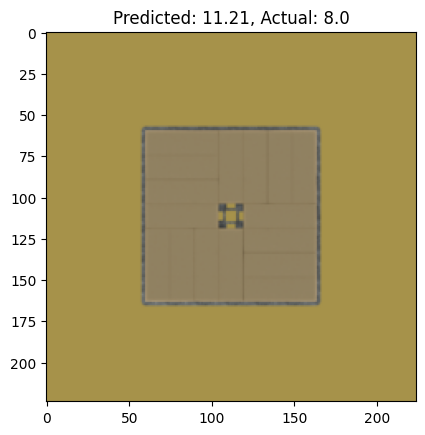

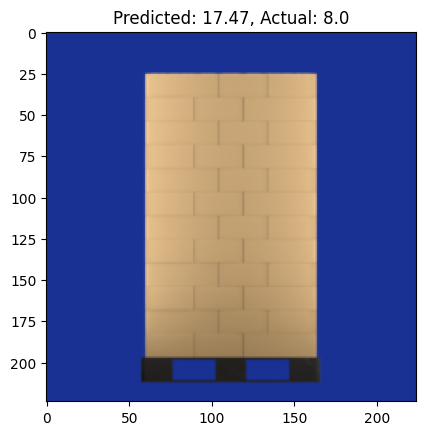

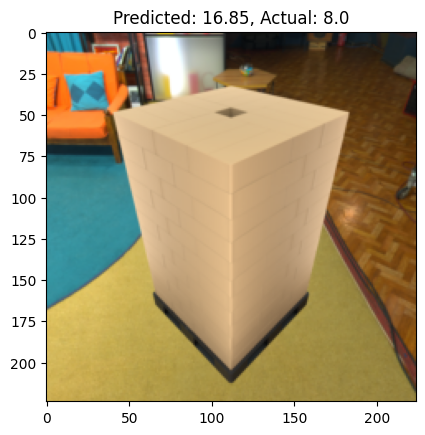

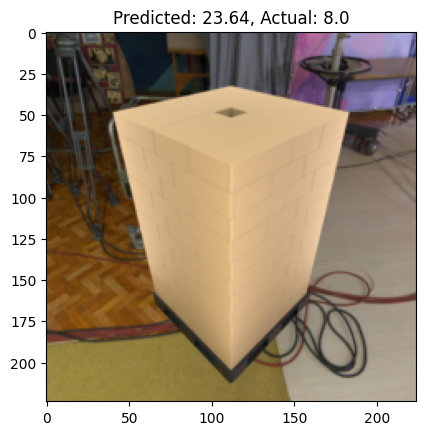

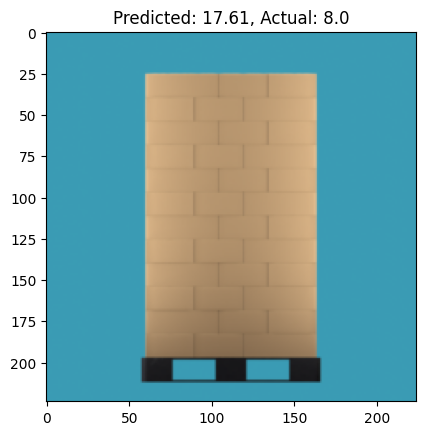

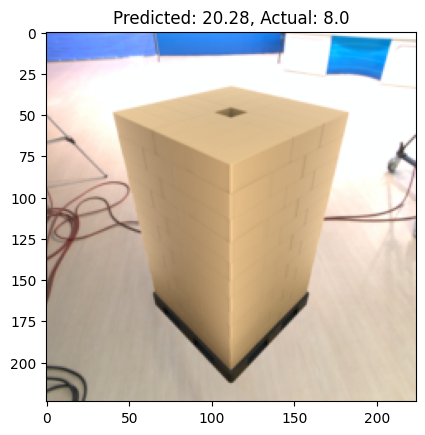

In [39]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            predictions = outputs.squeeze().cpu().numpy()
            actuals = labels.cpu().numpy()

            for j in range(len(predictions)):
                img = images[j].cpu().permute(1, 2, 0).numpy()
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = img.clip(0, 1)
                plt.imshow(img)
                plt.title(f'Predicted: {predictions[j]:.2f}, Actual: {actuals[j]}')
                plt.show()
                if i*len(predictions) + j >= 5:  # Show 5 examples
                    return

visualize_predictions(model, test_dataloader, device)
